In [1]:
import os, re
import numpy as np
import pickle as pkl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import speechpy
import shutil
import pandas as pd
from sklearn import preprocessing

In [2]:
def decode(path_from, path_to, file_name, separator):
    if not os.path.exists(path_to):
        os.makedirs(path_to)
    from pydub import AudioSegment
    try:
        sound = AudioSegment.from_mp3(os.path.abspath(path_from + file_name))
        sound.export(os.path.abspath(path_to)+separator+re.split('[.]', file_name)[0]+'.wav', format="wav")
        print('Successfully decoding ' + os.path.abspath(path_to+file_name) + ' to WAV')
    except Exception as e:
        file = os.path.abspath(path_to+file_name)
        print(f'Error: {file} - unsuccessfully decoding. ', e)

In [3]:
def extr_mfcc(path_from, file_name):
    try:
        fs, signal = wav.read(path_from+file_name)
        signal = signal[:,0]
    except Exception as e:
        print(f'Error: reading wav file {file_name}.', e)
    try:
        mfcc = speechpy.feature.mfcc(signal, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
                 num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
        mfcc_cmvn = speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
        mfcc_feature_cube = speechpy.feature.extract_derivative_feature(mfcc)
        return (mfcc, mfcc_cmvn, mfcc_feature_cube)
    except Exception as e:
        print("Error: feature extraction from file {file_name}.", e) 
        return (np.asarray([]), np.asarray([]), np.asarray([]))

In [4]:
def get_playlist(path, expantion):
    for l in [filename for filename in os.listdir(path) if expantion in filename]:
        yield l

In [5]:
def dump(file_name, path_to, data):
    if not os.path.exists(path_to):
        os.makedirs(path_to)
    pkl_name = re.split(r'\\',file_name)[-1][:-4]
    pkl.dump(data, open(path_to + pkl_name, 'wb'))

In [6]:
def plot_2d_features(features, range_from, range_to, plotname):
    #Showing mfcc_feat
    plt.figure(figsize = (20, 10))
    plt.title(plotname)
    plt.plot(features[range_from:range_to])
    plt.show()

In [7]:
def clear_dir(path):
    shutil.rmtree(os.path.abspath(path))

In [8]:
def normalize(features, linear = True):
    X = pd.DataFrame(features)
    scalar = None
    if linear:
        scalar = preprocessing.Normalizer()
    else:
        scalar = preprocessing.QuantileTransformer().fit(X)
    return scalar.transform(X)

In [12]:
def extract_features(path_from, path_to, tmp_path_for_wavs, separator, methode = 'mfcc', linear = True):
    if os.path.exists(tmp_path_for_wavs):
        clear_dir(tmp_path_for_wavs)
    for file_name in get_playlist(path_from, '.mp3'):
        #декодируем один трек во временную папку
        decode(path_from = path_from, path_to = tmp_path_for_wavs, file_name = file_name, separator = separator)
        #вытаскиваем все wav-ки из временной папки
        for wav_files in get_playlist(tmp_path_for_wavs, '.wav'):
            features = extr_mfcc(tmp_path_for_wavs,wav_files)
            if len(features[0]):
                if methode == 'mfcc':
                    dump(file_name, path_to, normalize(features[0], linear=linear))
                elif methode == 'mfcc_cmvn':
                    dump(file_name, path_to, normalize(features[1], linear=linear))
                elif methode == 'mfcc_feature_cube':
                    dump(file_name, path_to, normalize(features[2], linear=linear))
                else:
                    print("Error: incorrect methode's name")
                    exit()
            #вывод картинок на экран TODO удалить
            plot_2d_features(normalize(features[0]), 0,len(features[0]),'MFCC: '+file_name)
            plot_2d_features(normalize(features[1]), 0,len(features[1]),'MFCC_SMVN: '+file_name)
        clear_dir(tmp_path_for_wavs)

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\2Pac - Dear Mama.mp3 to WAV


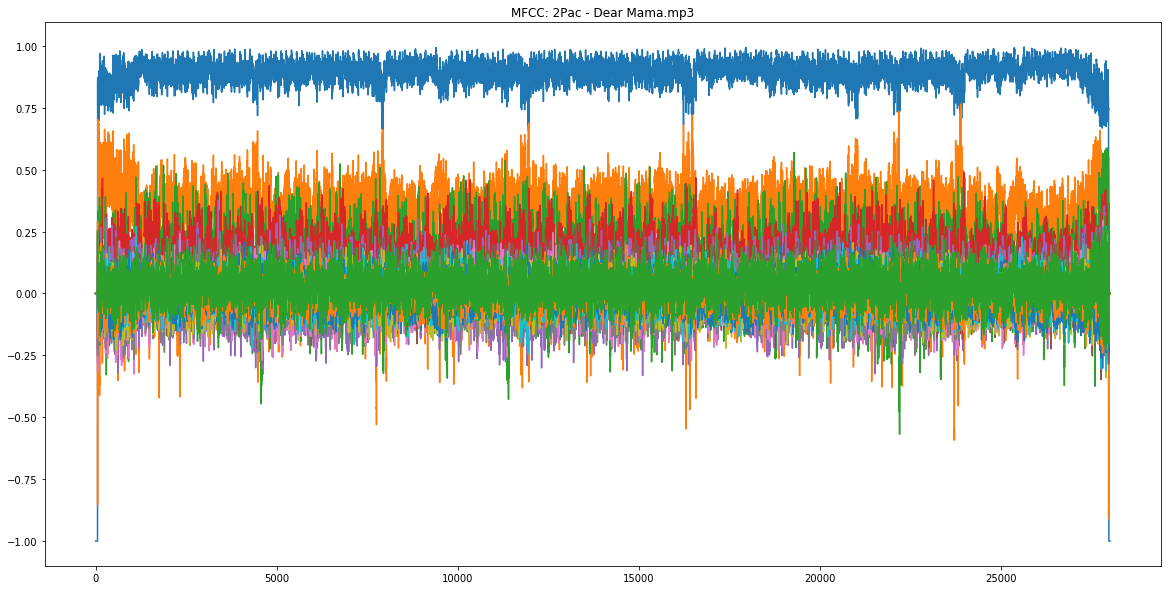

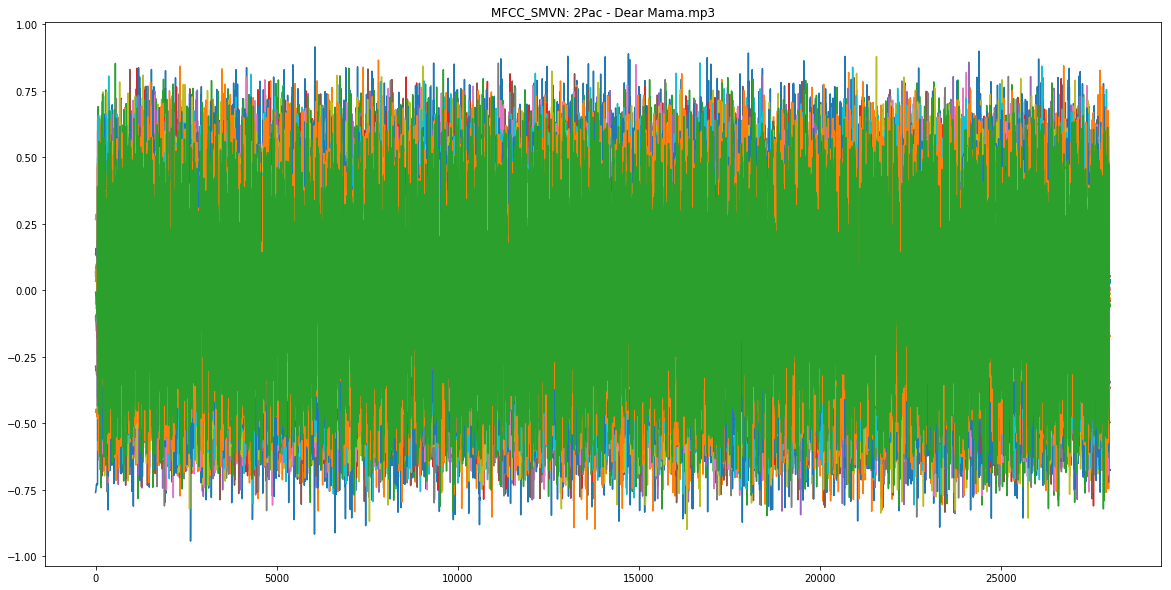

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\AC_DC - Hells Bells.mp3 to WAV


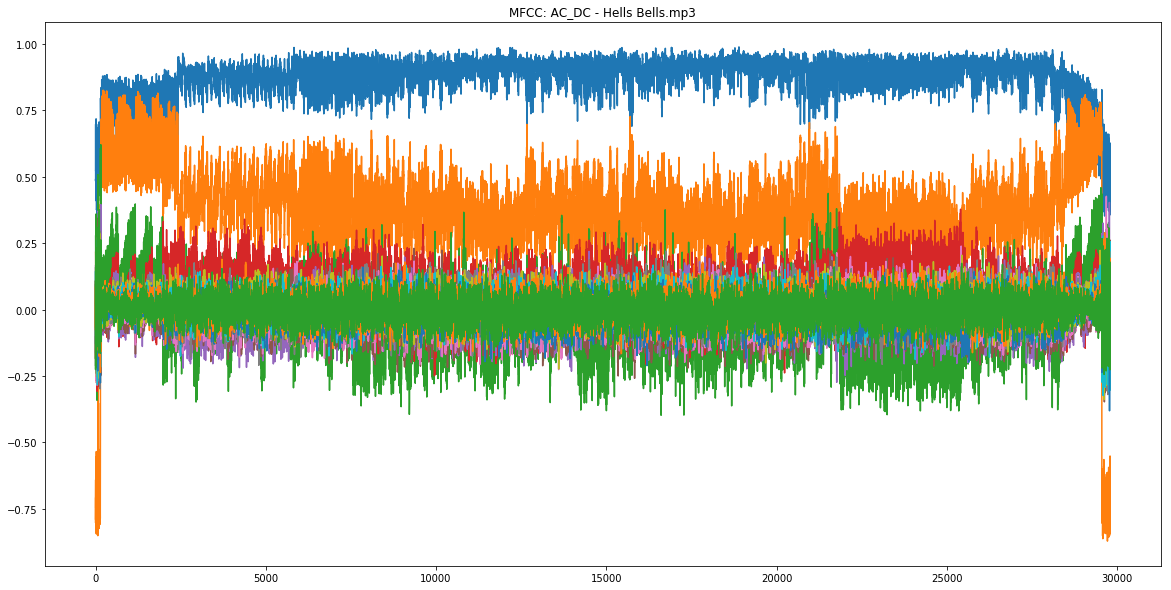

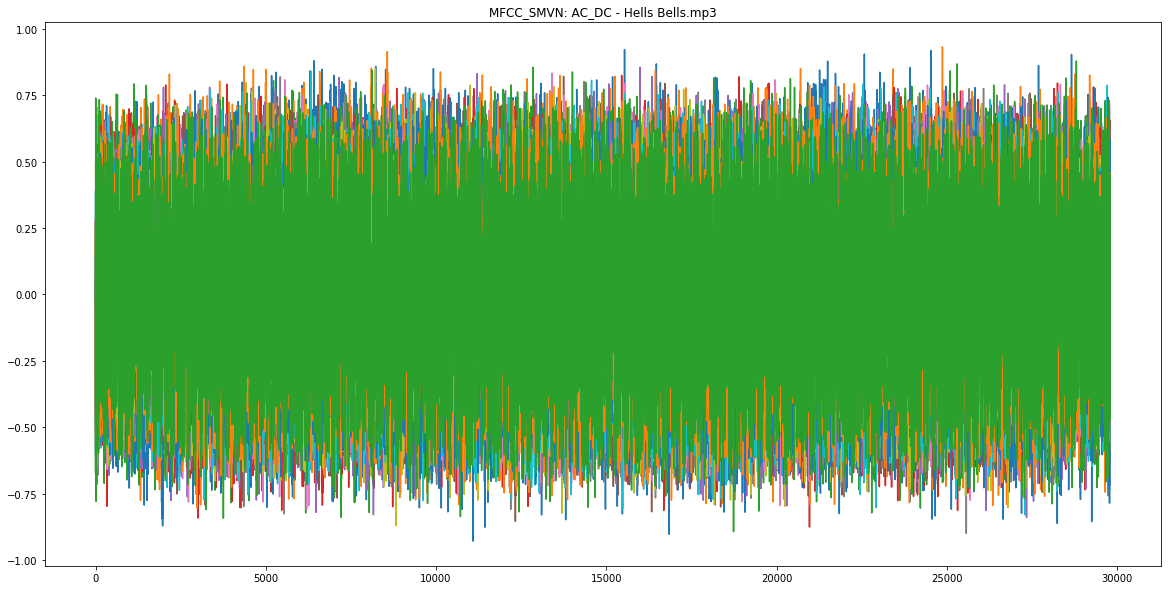

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\DJ Snake - Magenta Riddim.mp3 to WAV


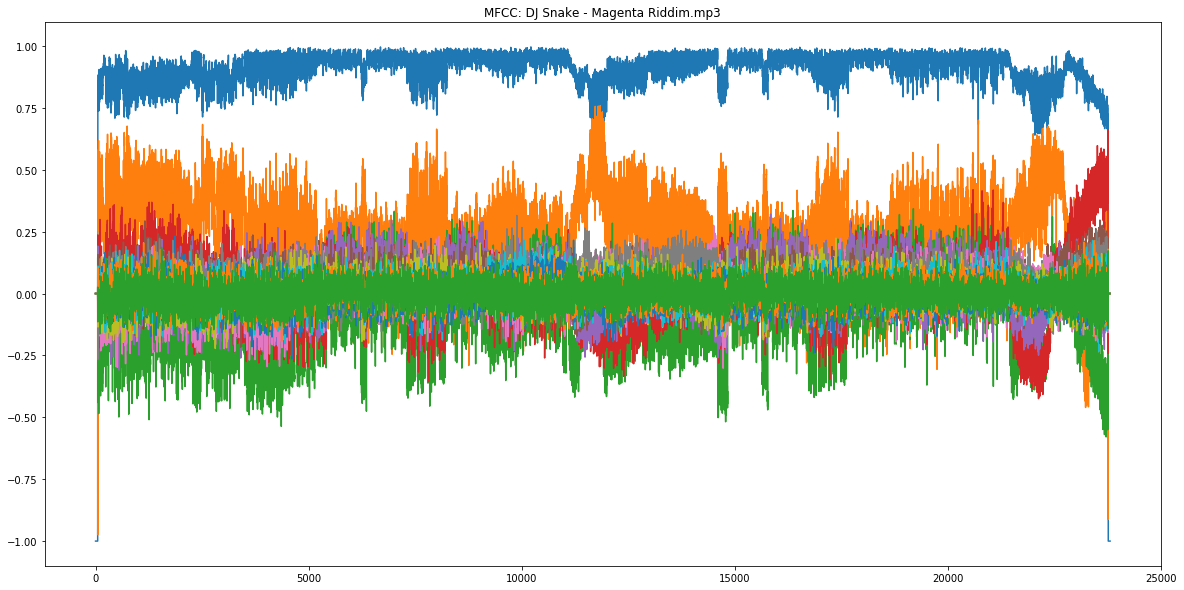

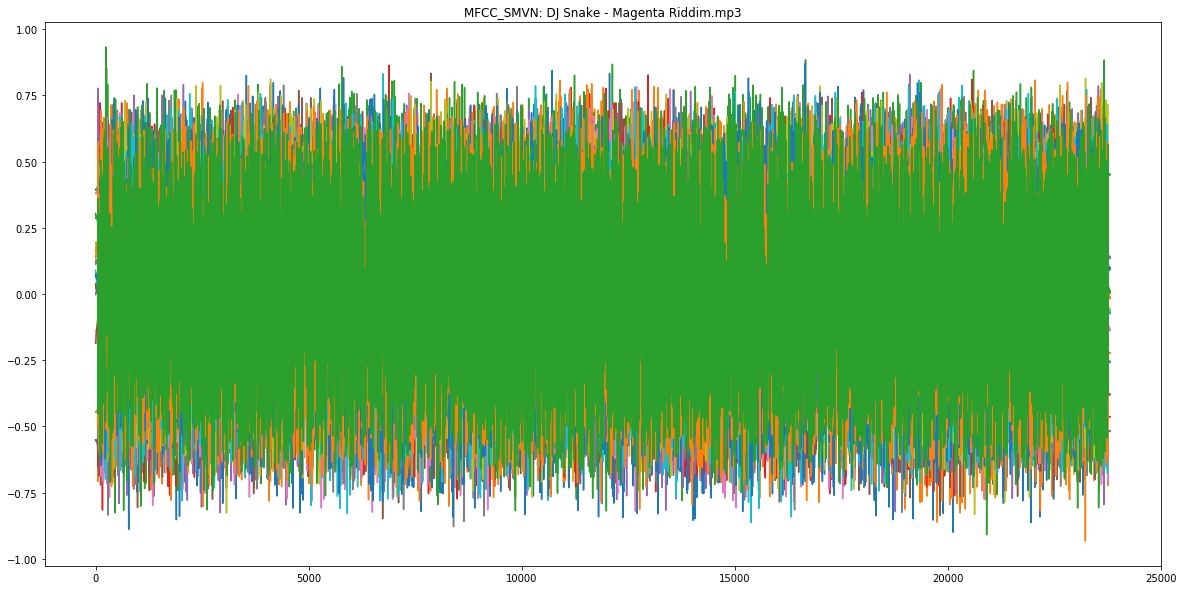

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\Elthon John - Sacrifice.mp3 to WAV


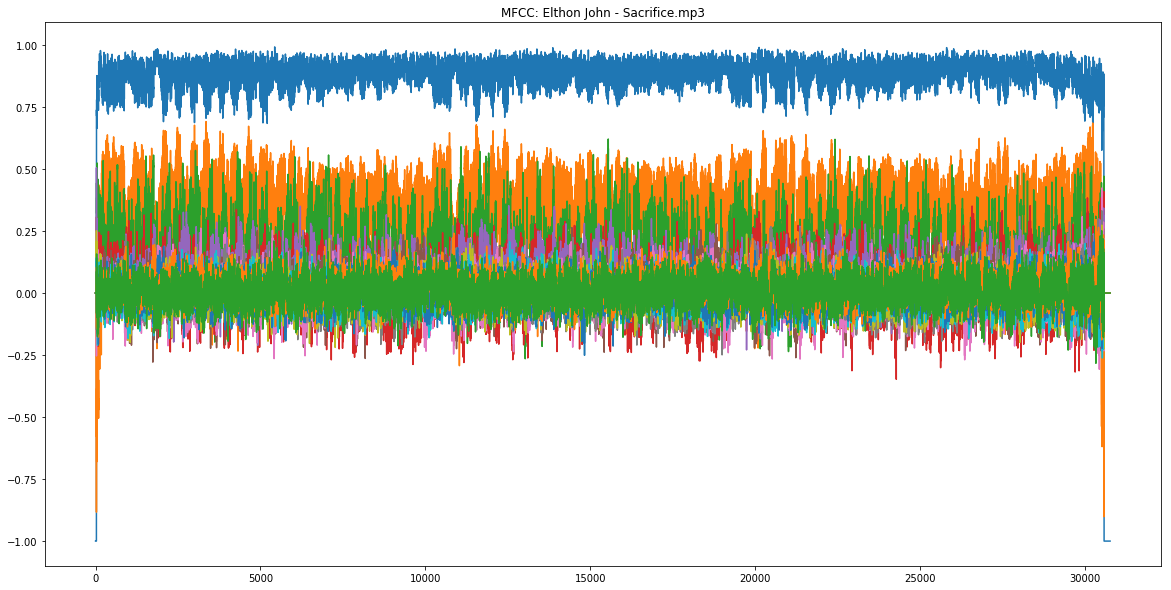

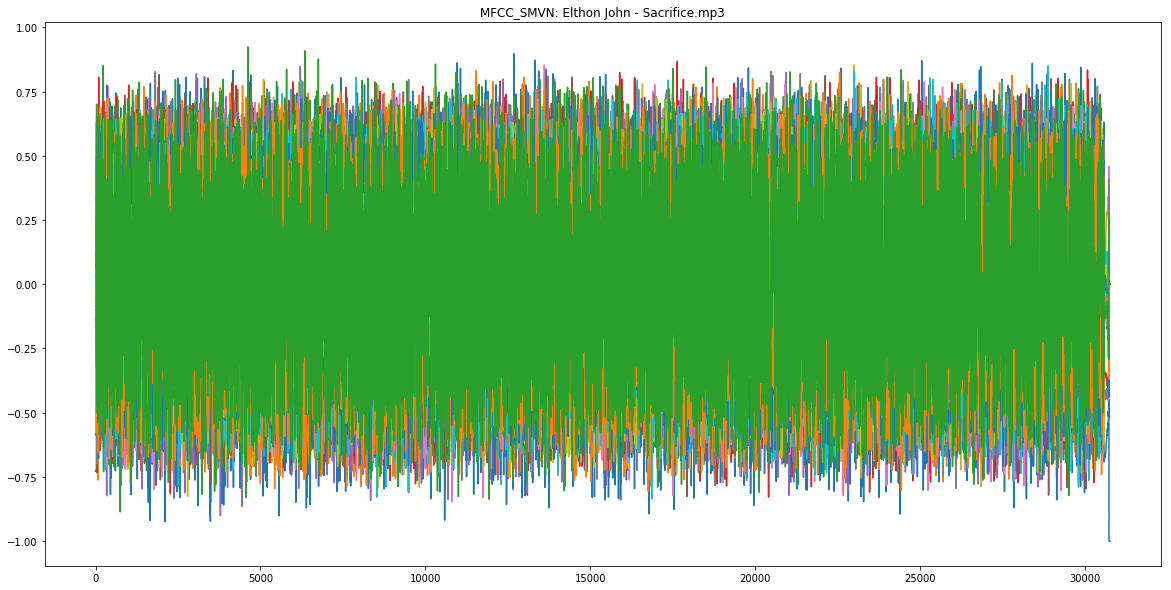

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\Eminem - Framed.mp3 to WAV


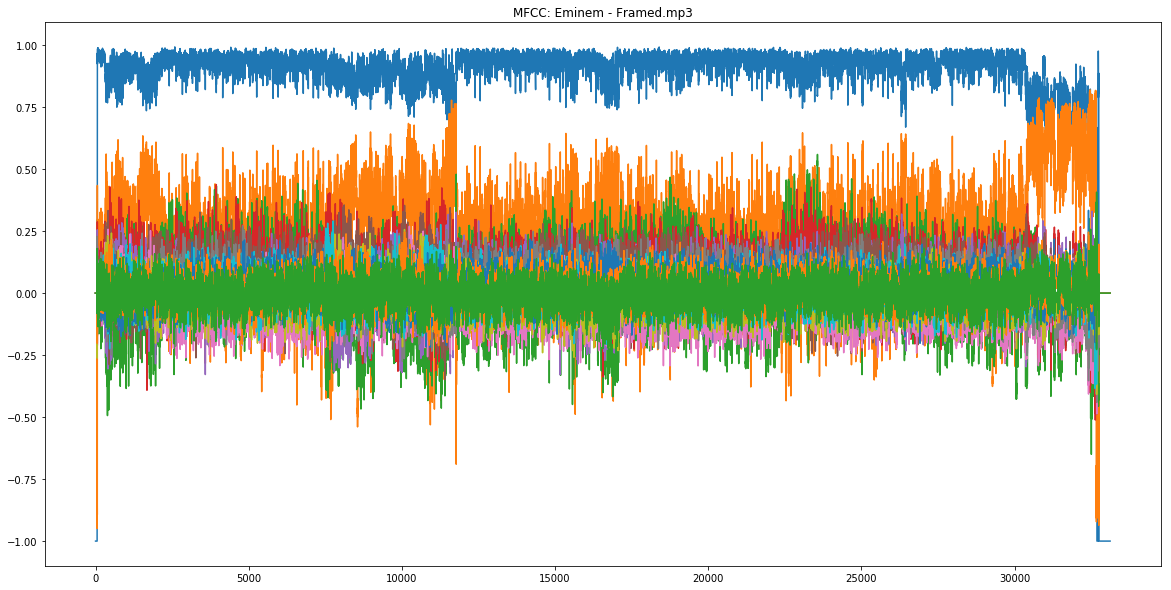

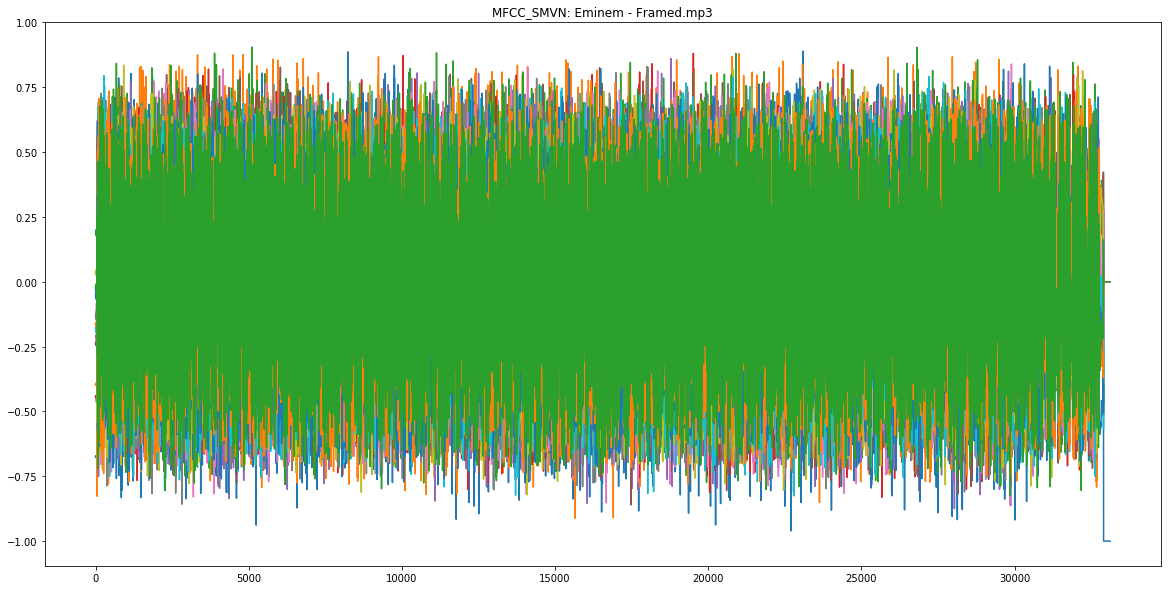

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\Godsmack - I Stand Alone.mp3 to WAV


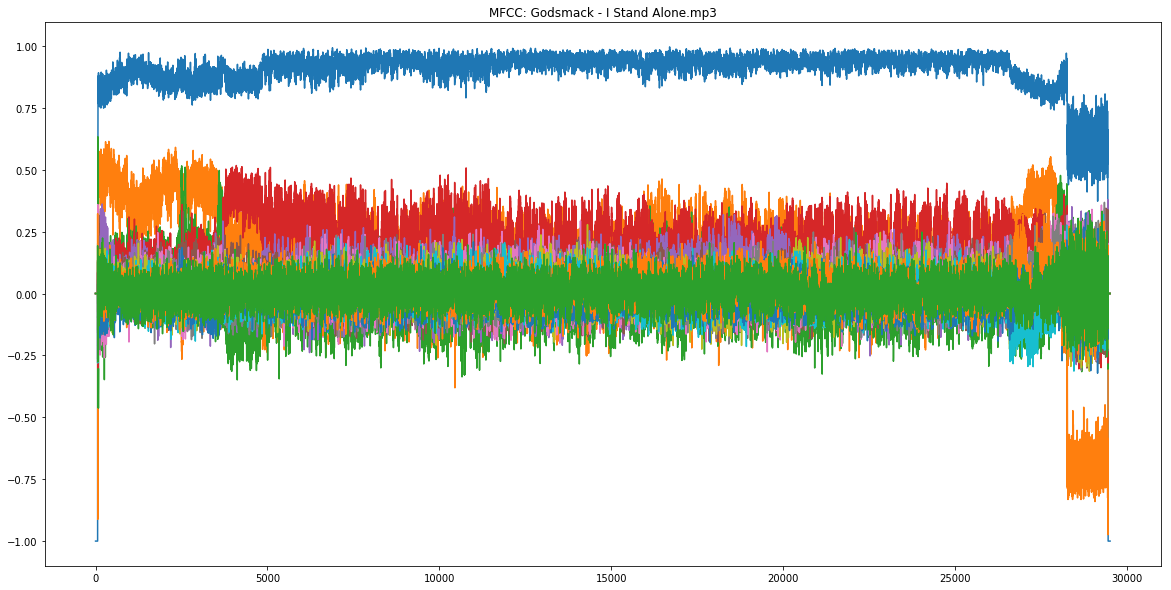

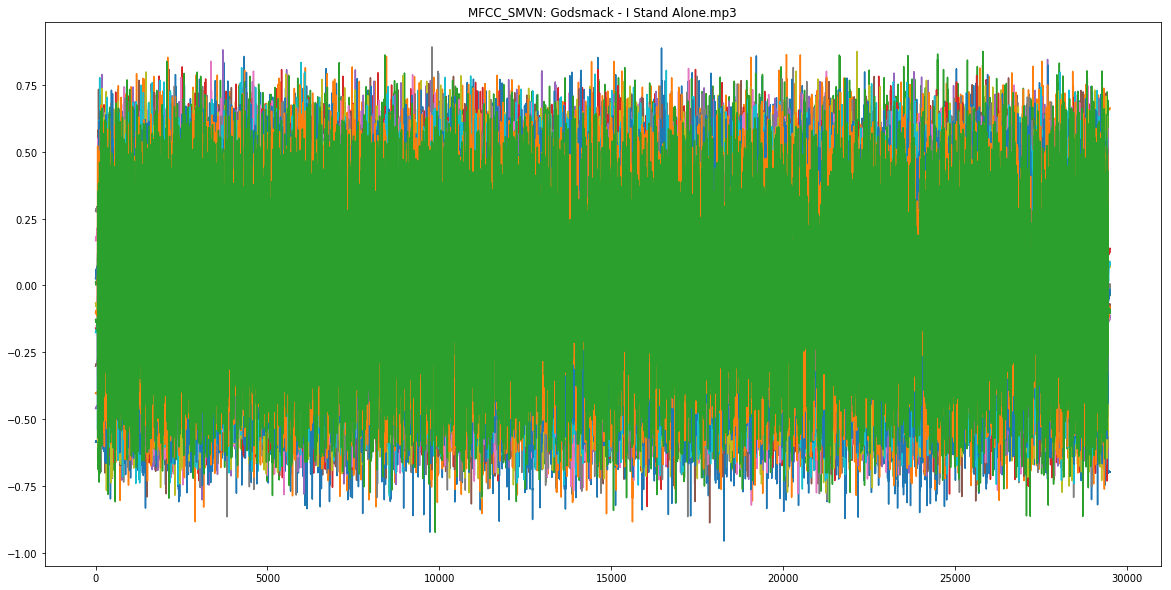

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\Mozart - Requiem in D minor Complete Full.mp3 to WAV


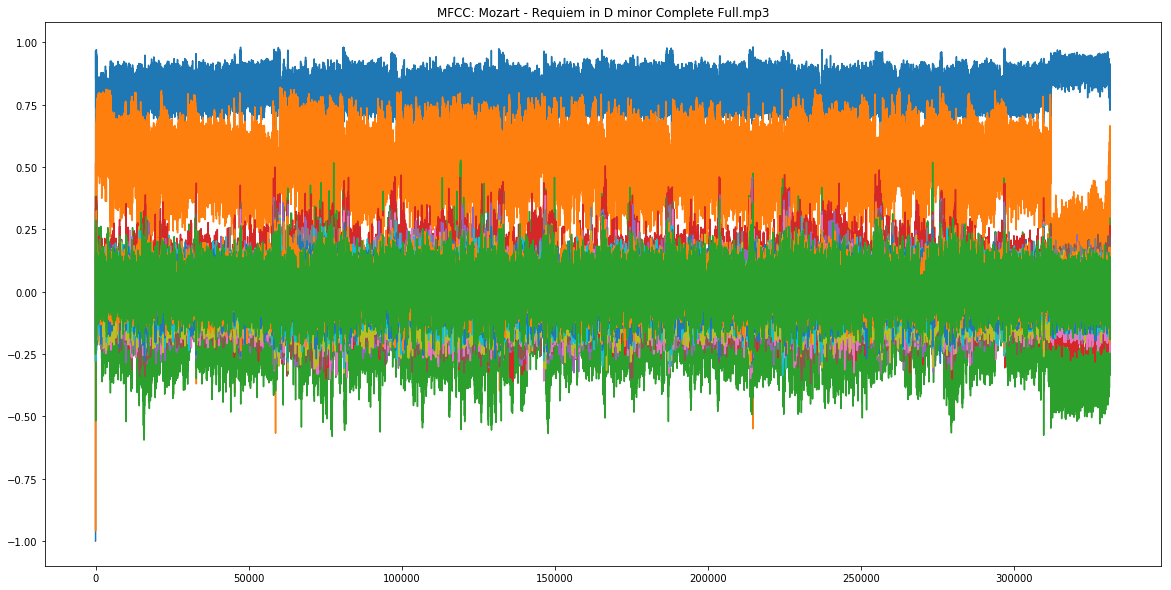

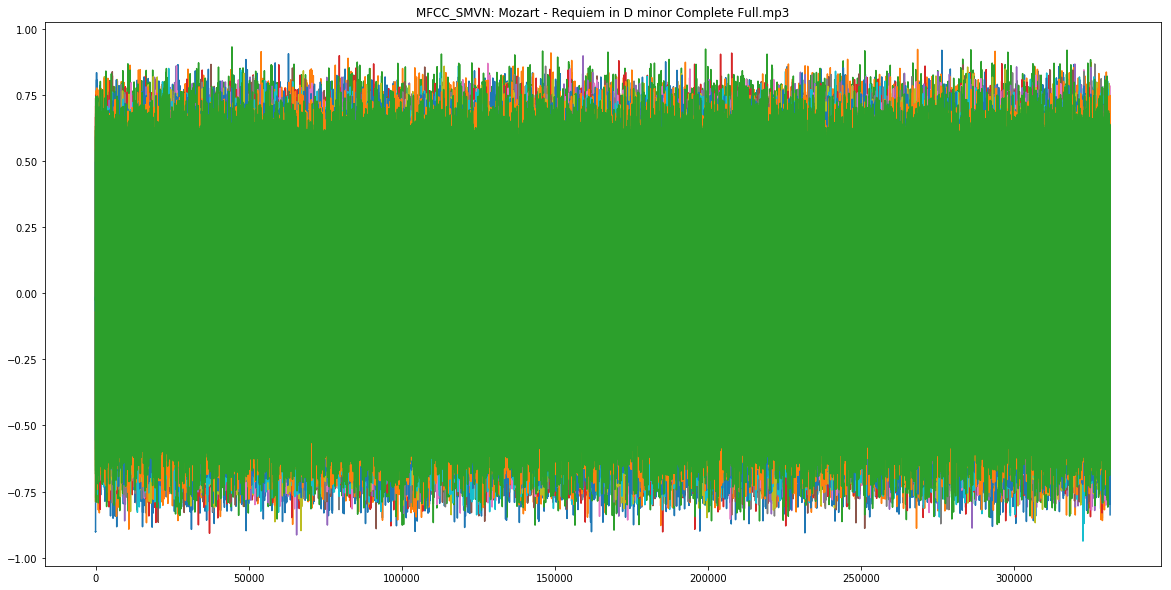

Successfully decoding c:\Users\Kozyrevsky-V\Documents\recom\RecomendationSystem\wavs\Nirvana - Lithium.mp3 to WAV


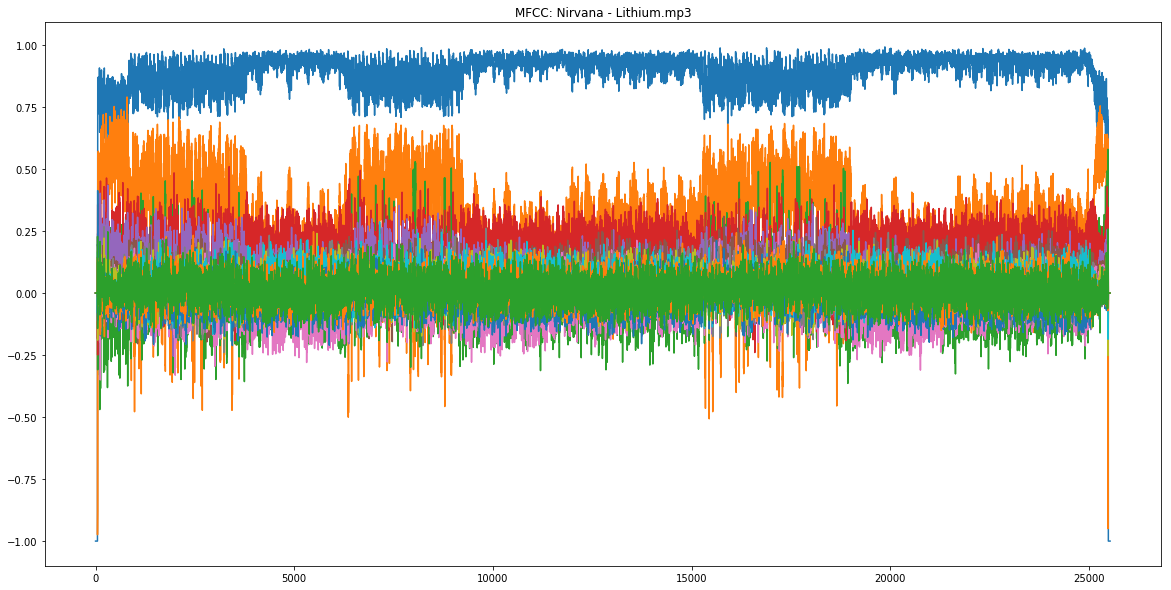

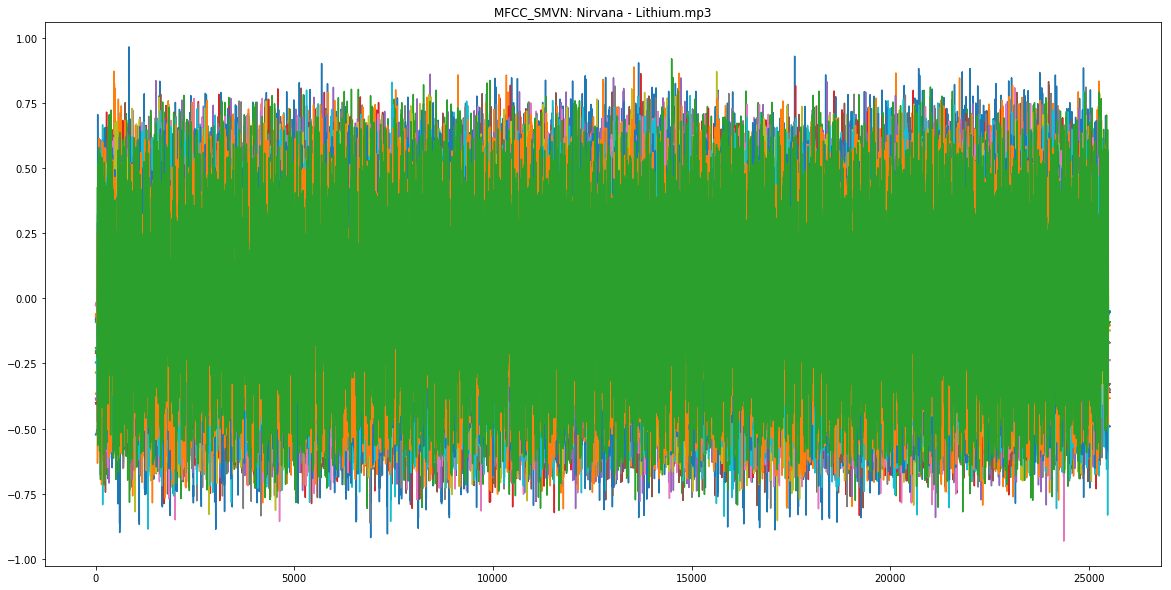

In [11]:
extract_features(path_from= '..\\tracks\\', path_to= '..\\mfccs\\', tmp_path_for_wavs='..\\wavs\\', separator= '\\')